# Pipeline & Demo: Adult Census dataset

This notebook showcases the usage of the NCorrFP on Adult Census dataset.

Contents:
1. [Data import](#1.-Data-import)

2. [Define fingerprinting scheme](#2.-Define-fingerprint-scheme)

3. [Insert fingerprint](#3.-Insert-fingerprint)

4. [Detect fingerprint](#4.-Detect-fingerprint)

5. [Inspect the algorithm (via demo)](#5.-Demo)

In [1]:
import sys
sys.path.insert(0, '../../../dissertation')  # make the script standalone for running on server

In [2]:
from datasets import Adult, AdultSample
from NCorrFP.NCorrFP import NCorrFP


import argparse
import os
from itertools import product
from pprint import pprint

## 1. Data import

In [3]:
data = Adult()
data.dataframe.head()

,Id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data.dataframe.shape

(32561, 16)

In [5]:
data.correlated_attributes

[['sex', 'relationship', 'marital-status'], ['education-num', 'education']]

In [6]:
data.columns

Index(['Id', 'age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

## 2. Define fingerprint scheme

In [7]:
param = {'gamma': 3,#, 4, 8, 16, 32],
              'k': int(0.01*data.dataframe.shape[0]), #, 1000], # 1% of data size
              'fingerprint_length': 100, #, 256, 512],#, 128, 256],  # , 128, 256],
              'n_recipients': 20,
              'sk': 100,
              'id': 0
             }

In [8]:
scheme = NCorrFP(gamma=param['gamma'], fingerprint_bit_length=param['fingerprint_length'], k=param['k'],
                             number_of_recipients=param['n_recipients'], fingerprint_code_type='tardos')

## 3. Insert fingerprint

In [9]:
fp_data = scheme.insertion(data, secret_key=param['sk'], recipient_id=param['id'],
                             correlated_attributes=data.correlated_attributes, save_computation=True, 
                           outfile='adult_fp_temp.csv')

Start the NCorr fingerprint insertion algorithm...
	gamma: 3
	k: 325
	correlated attributes: [['sex', 'relationship', 'marital-status'], ['education-num', 'education']]

Generated a tardos fingerprint for recipient 0: 1000111100010001110100100010110101101000011001111101010011001101010111010010110110101001011110010111
Inserting the fingerprint...

Training balltrees in: 1.1544 sec.
Fingerprint inserted.
Runtime: 99.27 sec.
{'query_time': 43.637449979782104, 'write_time': 2.6623411178588867, 'read_time': 0.15904450416564941, 'mark_time': 46.924524784088135}


In [10]:
fp_data.head()

,Id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,167613,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
df_diff = fp_data.head(20).compare(data.dataframe.head(20))
df_diff

age          fnlwgt               marital-status                      \
    self other      self     other               self               other   
2    NaN   NaN  167613.0  215646.0                NaN                 NaN   
5    NaN   NaN       NaN       NaN  Married-AF-spouse  Married-civ-spouse   
8    NaN   NaN       NaN       NaN                NaN                 NaN   
9   27.0  42.0       NaN       NaN                NaN                 NaN   
19   NaN   NaN       NaN       NaN                NaN                 NaN   

     sex         income        
    self   other   self other  
2    NaN     NaN    NaN   NaN  
5    NaN     NaN    NaN   NaN  
8    NaN     NaN  <=50K  >50K  
9    NaN     NaN    NaN   NaN  
19  Male  Female    NaN   NaN

## 4. Detect fingerprint

In [12]:
detected_fp, votes, suspect_probvec = scheme.detection(fp_data, secret_key=param['sk'],
                                                                   primary_key='Id',
                                                                   correlated_attributes=data.correlated_attributes,
                                                                   original_columns=list(data.columns))

Start NCorr fingerprint detection algorithm ...
	gamma: 3
	k: 325
	fp length: 100
	total # recipients: 20
	correlated attributes: [['sex', 'relationship', 'marital-status'], ['education-num', 'education']]
Training balltrees in: 1.1387 sec.
Fingerprint detected: 1000111100010001110100100010110101101000011001111101010011001101010111010010110110101001011110010111
[[10, 85], [94, 4], [101, 8], [89, 12], [10, 99], [8, 80], [4, 83], [9, 83], [92, 8], [80, 6], [77, 6], [6, 77], [97, 4], [86, 9], [67, 8], [8, 76], [9, 110], [9, 88], [90, 4], [4, 80], [79, 4], [75, 8], [4, 72], [72, 10], [91, 9], [78, 9], [2, 73], [90, 7], [8, 76], [3, 78], [89, 16], [4, 84], [90, 4], [10, 77], [9, 64], [71, 5], [8, 84], [84, 10], [93, 9], [83, 5], [85, 4], [9, 74], [7, 76], [85, 7], [91, 5], [6, 95], [5, 77], [5, 86], [5, 87], [1, 85], [78, 10], [7, 73], [100, 3], [11, 71], [82, 6], [84, 7], [8, 69], [8, 99], [82, 7], [87, 5], [7, 91], [14, 76], [92, 13], [9, 78], [91, 6], [10, 80], [69, 8], [10, 84], [6, 90]

## 5. Demo

In [13]:
from NCorrFP.demo import *

In [14]:
demo = Demo(scheme)

In [15]:
len(demo.get_error_iterations())

693

In [16]:
len(demo.detection_iter_log)

10723

In [17]:
len(demo.get_error_iterations())/len(demo.detection_iter_log)  # vote errors

0.06462743635176722

In [18]:
np.array(demo.get_error_iterations())[:30]

array([ 37,  42,  48,  62,  72,  79,  88, 102, 110, 194, 196, 201, 202,
       230, 237, 249, 252, 268, 269, 272, 284, 286, 327, 328, 334, 338,
       342, 344, 370, 378])

In [19]:
from collections import Counter

err_attrs = []
for e in demo.get_error_iterations():
    err_attrs.append(demo.detection_iter_log[e]['attribute'])
Counter(err_attrs)

Counter({'capital-loss': 56,
         'capital-gain': 356,
         'hours-per-week': 10,
         'marital-status': 146,
         'education': 41,
         'occupation': 9,
         'age': 35,
         'fnlwgt': 22,
         'sex': 2,
         'education-num': 9,
         'relationship': 3,
         'workclass': 1,
         'income': 3})

Marking record no. 243
Marking attribute: capital-gain
The record to mark: 
    Id  age  workclass  fnlwgt education  education-num      marital-status  \
79  79   31  Local-gov  125927   7th-8th              4  Married-civ-spouse   

         occupation relationship   race   sex  capital-gain  capital-loss  \
79  Farming-fishing      Husband  White  Male             0             0   

    hours-per-week native-country income  
79              40  United-States  <=50K  
------------------------------------------------------------------------------------------------------------------
Neighbourhood: capital-gain is not a correlated attribute, so we are including all attributes to find the closest neighbourhood.
Neighbours idx: [  243  9304 15206 32124 12794  5041 10224  4926 16305  9175 29651  6924
 12487 15929  4446 25160 19256  9558 15155  3051 32543  7781 11587 15297
 26535 13649  1316 10457 18214 24561 16179  3154  1383 27838  8393 28217
 31594  2158 16933   342 19932  1648 19523 25

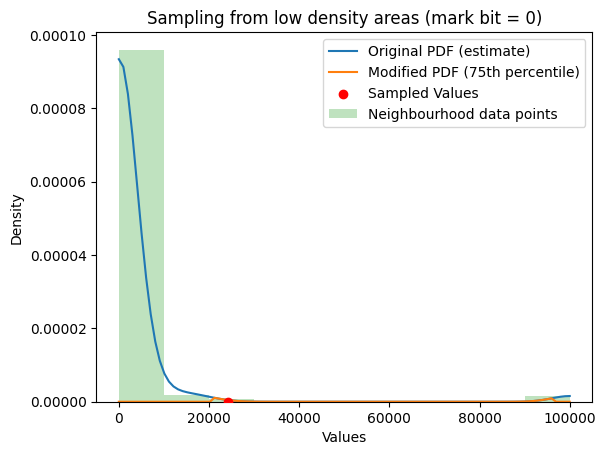

The sampled continuous value is rounded to the closest existing value from the data (to avoid perceptibility of marks) and is: 20051
The fingerprinted record is:
    Id  age  workclass  fnlwgt  education  education-num  marital-status  \
79  79   31          2  125927          5              4               2   

    occupation  relationship  race  sex  capital-gain  capital-loss  \
79           5             0     4    1             0             0   

    hours-per-week  native-country  income  
79              30              39       0  


In [20]:
demo.show_embedding_iteration(79)

Detecting from record at idx: 9
Detecting from attribute: age
   Id  age  workclass  fnlwgt  education  education-num  marital-status  \
4   4   28          4  338409          9             13               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
4          10             5     2    0             0             0   

   hours-per-week  native-country  income  
4              40               5       0  
Fingerpritned value: 27
----------------------------------------------------------
Obtaining neighbourhood....
Target values:[27, 60, 34, 45, 36, 35, 61, 62, 38, 25, 50, 29, 53, 59, 59, 69, 70, 50, 50, 53, 50, 65, 30, 51, 61, 39, 61, 37, 64, 29, 45, 39, 24, 71, 34, 55, 55, 42, 23, 59, 29, 48, 50, 35, 57, 51, 42, 64, 31, 53, 31, 54, 28, 41, 51, 23, 34, 28, 33, 51, 56, 30, 38, 72, 72, 44, 41, 66, 27, 28, 50, 30, 48, 48, 47, 41, 33, 29, 34, 47, 26, 30, 44, 70, 33, 39, 27, 37, 45, 40, 60, 39, 24, 43, 41, 60, 33, 43, 34, 30, 59, 29, 47, 58, 32, 67, 33, 43, 

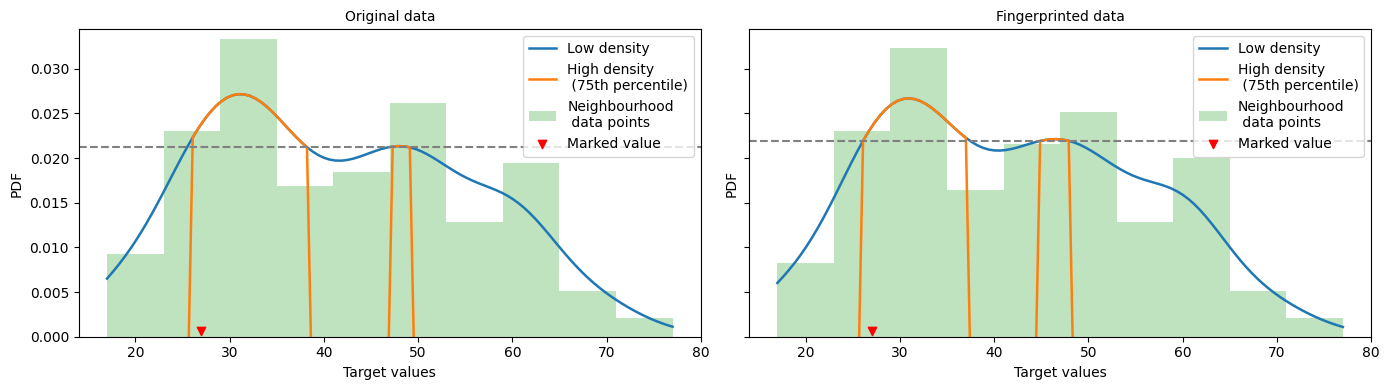

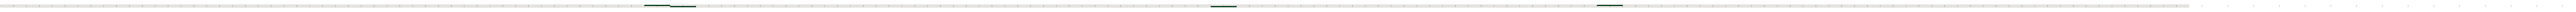

Table: fingerprint count updates after this iteration (iteration 4). Each column is one fingerprint bit position (e.g. 16-bit --> 16 columns), and each row represents votes for either 0 or 1 being the value of that bit. The final decision is made at the end af the detection algorithm according to majority vote.


In [21]:
# one continuous example
demo.show_detection_iteration(4, plotting_style='paper', save_fig='../figures/demo_continuous.png')

Detecting from record at idx: 6
Detecting from attribute: workclass
   Id  age  workclass  fnlwgt  education  education-num  marital-status  \
2   2   38          4  167613         11              9               0   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
2           6             1     4    1             0             0   

   hours-per-week  native-country  income  
2              40              39       0  
Fingerpritned value: 4
----------------------------------------------------------
Obtaining neighbourhood....
Target values:[4, 2, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 2, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 2, 4, 2, 0, 4, 0, 4, 4, 4, 4, 4, 4, 1, 7, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4, 4, 0, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4

C:\Users\tsarcevic\PycharmProjects\dissertation\NCorrFP\notebooks\../../../dissertation\NCorrFP\demo.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(sorted_categories_ins, rotation=35)
C:\Users\tsarcevic\PycharmProjects\dissertation\NCorrFP\notebooks\../../../dissertation\NCorrFP\demo.py:609: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(sorted_categories_ins, rotation=35)



--> Observing the distribution of target attribute workclass below...
Mark bit (where in distribution falls the target value?): 1 (i.e. in densest area)
Mask bit (from PRNG): 1
Fingerprint bit index (from PRNG): 25
Fingerprint bit value (mark bit xor mask bit): 0

Fingerprint bit CORRECT :)


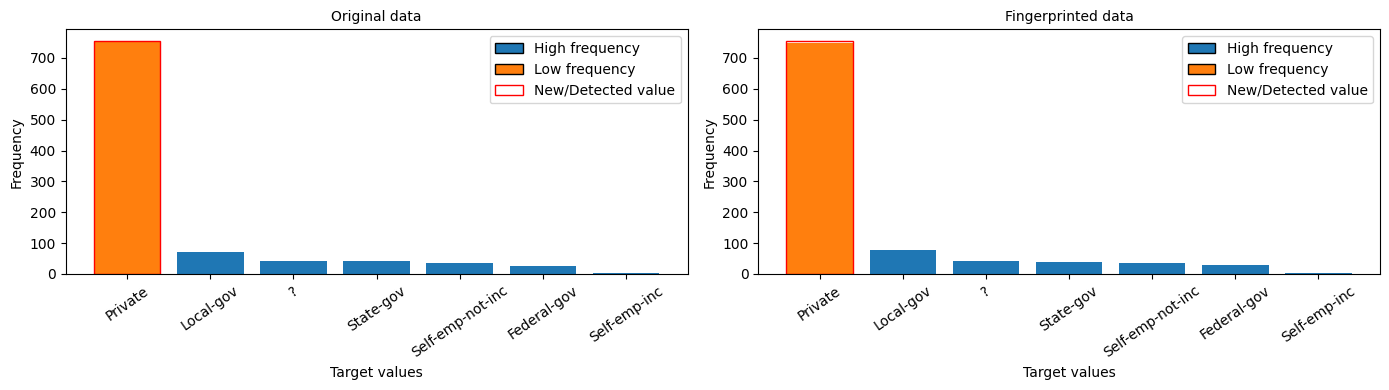

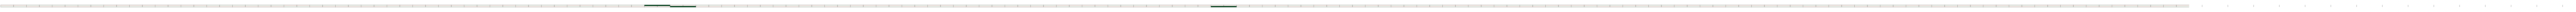

Table: fingerprint count updates after this iteration (iteration 2). Each column is one fingerprint bit position (e.g. 16-bit --> 16 columns), and each row represents votes for either 0 or 1 being the value of that bit. The final decision is made at the end af the detection algorithm according to majority vote.


In [22]:
# one categorical example
demo.show_detection_iteration(2, plotting_style='paper', save_fig='../figures/demo_categorical.png')